In [1]:
import numpy as np
from numpy import random

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import math

In [5]:
from scipy.stats import bernoulli

# Functions

In [6]:
def sample_service_times(num_jobs, parameter):
    a = parameter
    return np.array([math.floor(t)+100 for t in random.pareto(a, num_jobs)])

In [7]:
def remaining_jobs(remaining_service_times):
    return np.array([i for i in range(N) if remaining_service_times[i] >= 1])

def holding_cost(mean_values, jobs):
    return np.sum([mean_values[i] for i in jobs])

In [8]:
def select_job(t, samples, service_times, jobs):
    c_mu = np.array([(np.mean(samples[i][0:t+1]) / service_times[i]) for i in jobs])
    return jobs[np.argmax(c_mu)]

def serve(i, remaining_service_times):
    remaining_service_times[i] -= 1
    
def complete(i, remaining_service_times):
    remaining_service_times[i] = 0

In [9]:
def optimal(mean_values, service_times):
    sorted_jobs = np.argsort(- mean_values / service_times)
    total_cost = 0
    for i in range(N):
        for j in range(N):
            if j>= i:
                total_cost += mean_values[sorted_jobs[j]] * service_times[sorted_jobs[i]]
    return total_cost

In [10]:
def preemptive(mean_values, service_times, samples):
    remaining_service_times = service_times
    initial_times = np.array([service_times[i] for i in range(N)])
    total_holding_cost = 0
    active_jobs = np.array(range(N))
    t = 0
    while active_jobs.size > 1:
        total_holding_cost += holding_cost(mean_values, active_jobs)
        #serve(select_job(t, samples, service_times, active_jobs), remaining_service_times)
        serve(select_job(t, samples, initial_times, active_jobs), remaining_service_times)
        active_jobs = remaining_jobs(remaining_service_times)
        t += 1
    total_holding_cost += remaining_service_times[active_jobs[0]] * mean_values[active_jobs[0]]
    return total_holding_cost

In [11]:
def nonpreemptive(mean_values, service_times, samples):
    remaining_service_times = service_times
    total_holding_cost = 0
    t = 0
    for i in range(N):
        active_jobs = remaining_jobs(remaining_service_times)
        selected = select_job(t, samples, service_times, active_jobs)
        total_holding_cost += remaining_service_times[selected]*holding_cost(mean_values, active_jobs)
        t +=  remaining_service_times[selected]
        complete(selected, remaining_service_times)
    return total_holding_cost

In [12]:
def preemptive_then_nonpreemptive(mean_values, service_times, samples):
    max_service_time = np.max(service_times)
    S = math.floor( (max_service_time**(2/3)) * (np.log(N*max_service_time)) / C)
    S = np.min([np.min(service_times), S])
    remaining_service_times = service_times
    total_holding_cost = 0

    active_jobs = np.array(range(N))
    for t in range(S):
        total_holding_cost += holding_cost(mean_values, active_jobs)
        serve(select_job(t, samples, service_times, active_jobs), remaining_service_times)
        active_jobs = remaining_jobs(remaining_service_times)
    
    time_steps_past = S
    while active_jobs.size > 0:
        job_chosen = select_job(time_steps_past, samples, service_times, active_jobs)
        remaining_service_time = remaining_service_times[job_chosen]
        total_holding_cost += remaining_service_time*holding_cost(mean_values, active_jobs)
        time_steps_past += remaining_service_time
        complete(job_chosen, remaining_service_times)
        active_jobs = remaining_jobs(remaining_service_times)
    return total_holding_cost

## Sampling mean holding costs

In [13]:
eps_list = np.array([0.01*i for i in range(51)])
eps_list[0] = 0.001

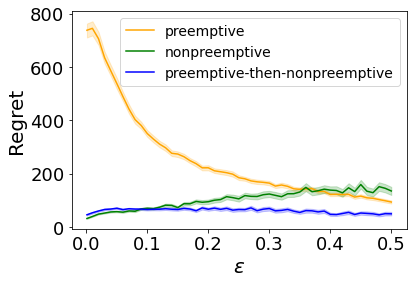

In [7]:
df = pd.read_csv('results/heterogeneous/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 10000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive'], label='preemptive', color = 'orange')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive'], label='nonpreemptive', color = 'green')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre'], label='preemptive-then-nonpreemptive', color = 'blue')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks([0,200,400,600,800],fontsize=18)
plt.savefig('hetero-regret.pdf', bbox_inches = 'tight')

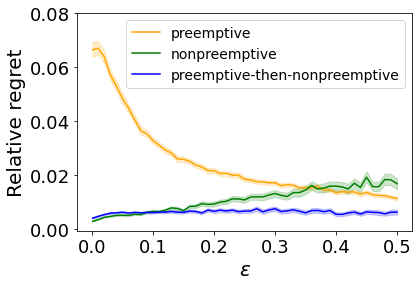

In [9]:
df = pd.read_csv('results/heterogeneous/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 10000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive']/filtered['OPT'], label='preemptive', color = 'orange')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive']/filtered['OPT'], label='nonpreemptive', color = 'green')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre']/filtered['OPT'], label='preemptive-then-nonpreemptive', color = 'blue')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Relative regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks([0,0.02, 0.04, 0.06, 0.08],fontsize=18)
plt.savefig('hetero-relative.pdf', bbox_inches = 'tight')